In [2]:
import pandas as pd, numpy as np
from vivarium import Artifact

from pathlib import Path

from math import floor

import matplotlib.pyplot as plt

import pdb

In [3]:
FORECASTED_POP_KEY = "population.structure"
SCALING_FACTOR_KEY = "population.scaling_factor"
ACMR_KEY = "cause.all_causes.cause_specific_mortality_rate"
CSMR_KEY = "cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
BBBM_INCIDENCE_KEY = "cause.alzheimers.susceptible_to_bbbm_transition_count"
TIME_STEP_YEARS = 1
GBD_AGE_GROUP_YEARS = 5
TIME_STEPS_PER_AGE_GROUP = GBD_AGE_GROUP_YEARS / TIME_STEP_YEARS

SIM_START = 2023
SIM_END = 2100

In [4]:
def load_artifact(location, artifacts_dir):
    art_filename = f"{location.lower().replace(' ', '_')}.hdf"
    return Artifact(Path(artifacts_dir) / art_filename)

In [5]:
def initialize_pop_table(location, artifacts_dir):
    art = load_artifact(location, artifacts_dir)
    forecasted_pop = (
        art.load(FORECASTED_POP_KEY)
        .query("year_start == 2021 & age_start >=60 & age_start<80")
        .mean(axis=1)
        .droplevel(["location", "year_start", "year_end"])
    )
    all_states_prev = (
        art.load(SCALING_FACTOR_KEY)
        .query("age_start >=60 & age_start<80")  # only 2023 data
        .mean(axis=1)
        .droplevel(["year_start", "year_end"])
    )
    groups = forecasted_pop * (1 - all_states_prev)
    # build table with rows where age_end - age_start = time step (1 year)
    table = pd.Series(
        index=pd.MultiIndex.from_tuples([], names=list(groups.index.names))
    )
    for index, value in groups.items():
        (sex, age_start, age_end) = index
        while age_start < age_end:
            table.loc[(sex, age_start, age_start + 1)] = (
                value / TIME_STEPS_PER_AGE_GROUP
            )  # divide GBD age groups evenly (TBD - how does engineering do this?)
            age_start += 1
    return table

In [6]:
location = "United States of America"
artifacts_dir = (
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0"
)
# population table of people in location ages 60-80 who do not have pre-clinical, MCI or AD
pop_table = initialize_pop_table(location, artifacts_dir)
pop_table

sex     age_start  age_end
Female  60.0       61.0       2.200912e+06
        61.0       62.0       2.200912e+06
        62.0       63.0       2.200912e+06
        63.0       64.0       2.200912e+06
        64.0       65.0       2.200912e+06
        65.0       66.0       1.924770e+06
        66.0       67.0       1.924770e+06
        67.0       68.0       1.924770e+06
        68.0       69.0       1.924770e+06
        69.0       70.0       1.924770e+06
        70.0       71.0       1.585602e+06
        71.0       72.0       1.585602e+06
        72.0       73.0       1.585602e+06
        73.0       74.0       1.585602e+06
        74.0       75.0       1.585602e+06
        75.0       76.0       1.003150e+06
        76.0       77.0       1.003150e+06
        77.0       78.0       1.003150e+06
        78.0       79.0       1.003150e+06
        79.0       80.0       1.003150e+06
Male    60.0       61.0       2.049056e+06
        61.0       62.0       2.049056e+06
        62.0       63.0    

In [7]:
def get_prev_table_index(cur_index):
    (sex, age_start, age_end) = cur_index
    return (sex, age_start - TIME_STEP_YEARS, age_end - TIME_STEP_YEARS)

In [8]:
def run_time_step(pop_table, year, new_entrants, bbbm_incidence, mortality):
    person_time = dict({"year": year})
    person_time["deaths"] = 0
    person_time["exits_to_sim"] = 0
    person_time["incidence"] = 0
    for index, _ in pop_table.iloc[::-1].items():  # iterate in reverse order
        (sex, age_start, _) = index
        prev_index = get_prev_table_index(index)
        lookup_year = min(year, 2050)

        if age_start == 60:  # add incident 60 year olds:
            pop_table.loc[index] = (
                new_entrants.loc[(sex, lookup_year)] / GBD_AGE_GROUP_YEARS
            )
            person_time["incidence"] += pop_table.loc[index]
        else:  # copy population from the age group below this one
            # move people into new age groups:
            pop_table.loc[index] = pop_table.loc[prev_index]

            # mortality:
            age_group_start = (
                floor((age_start - 1) / GBD_AGE_GROUP_YEARS) * GBD_AGE_GROUP_YEARS
            )  # previous age_start, rounded to GBD age group boundaries

            index_in_groups = (
                sex,
                age_group_start,
                age_group_start + 5,
                lookup_year,
                lookup_year + 1,
            )
            person_time["deaths"] += (
                pop_table.loc[index] * mortality.loc[index_in_groups]
            )
            pop_table.loc[index] *= 1 - mortality.loc[index_in_groups]

            # remove people entering sim (incident to pre-clinical):
            person_time["exits_to_sim"] += (
                bbbm_incidence.loc[index_in_groups] / GBD_AGE_GROUP_YEARS
            )
            pop_table.loc[index] -= (
                bbbm_incidence.loc[index_in_groups] / GBD_AGE_GROUP_YEARS
            )

        person_time[age_start] = pop_table.loc[index]
    return person_time

In [9]:
def load_background_mortality():
    # copied from loader.py
    art = load_artifact(location, artifacts_dir)
    acmr = art.load(ACMR_KEY)
    csmr = art.load(CSMR_KEY).droplevel(["year_start", "year_end"])

    # for now, assume csmr is the same for all years based on docs
    csmr_all_years = pd.DataFrame(csmr, index=acmr.index)
    return (
        (acmr - csmr_all_years).query("age_start >= 60 & age_start < 80").mean(axis=1)
    )

In [10]:
# calculate 60 to 61 year olds who are not in simulation for each forecast year
art = load_artifact(location, artifacts_dir)
new_entrants_forecasted = (
    art.load(FORECASTED_POP_KEY)
    .query("age_start == 60")
    .mean(axis=1)
    .droplevel(["location", "age_start", "age_end", "year_end"])
)
new_entrants_all_states_prev = (
    art.load(SCALING_FACTOR_KEY)
    .query("age_start == 60")  # only 2023 data
    .mean(axis=1)
    .droplevel(["age_start", "age_end", "year_start", "year_end"])
)
new_entrants = (
    new_entrants_forecasted * (1 - new_entrants_all_states_prev) / GBD_AGE_GROUP_YEARS
)

background_mortality = load_background_mortality()

bbbm_incidence_counts = (
    art.load(BBBM_INCIDENCE_KEY).query("age_start >= 60 & age_start < 80").mean(axis=1)
)

# person-time observer
person_time = []


for year in range(SIM_START, SIM_END):
    year_person_time = run_time_step(
        pop_table, year, new_entrants, bbbm_incidence_counts, background_mortality
    )
    person_time.append(year_person_time)


age_groups = (
    pd.DataFrame(person_time)
    .drop(["deaths", "exits_to_sim", "incidence"], axis=1)
    .set_index("year")
)
age_groups = age_groups[age_groups.columns[::-1]]  # reverse order
categories = pd.DataFrame(person_time)[
    ["year", "deaths", "exits_to_sim", "incidence"]
].set_index("year")
display(age_groups)
display(categories)

,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0
year,,,,,,,,,,,,,,,,,,,,
2023,438447.936633,2.177281e+06,2.177281e+06,2.177281e+06,2.177281e+06,2.177281e+06,1.890615e+06,1.890615e+06,1.890615e+06,1.890615e+06,1.890615e+06,1.538504e+06,1.538504e+06,1.538504e+06,1.538504e+06,1.538504e+06,9.550324e+05,9.550324e+05,9.550324e+05,9.550324e+05
2024,435050.562104,4.283973e+05,2.154004e+06,2.154004e+06,2.154004e+06,2.154004e+06,2.140400e+06,1.856798e+06,1.856798e+06,1.856798e+06,1.856798e+06,1.838245e+06,1.492096e+06,1.492096e+06,1.492096e+06,1.492096e+06,1.474460e+06,9.070936e+05,9.070936e+05,9.070936e+05
2025,430918.174620,4.251112e+05,4.185081e+05,2.131112e+06,2.131112e+06,2.131112e+06,2.117448e+06,2.103987e+06,1.823383e+06,1.823383e+06,1.823383e+06,1.805013e+06,1.786771e+06,1.446423e+06,1.446423e+06,1.446423e+06,1.428458e+06,1.411305e+06,8.594819e+05,8.594819e+05
2026,426853.574342,4.210933e+05,4.153298e+05,4.087759e+05,2.108592e+06,2.108592e+06,2.094900e+06,2.081379e+06,2.068059e+06,1.790392e+06,1.790392e+06,1.772079e+06,1.754014e+06,1.736074e+06,1.401377e+06,1.401377e+06,1.383281e+06,1.365806e+06,1.349120e+06,8.123265e+05
2027,422703.035606,4.171508e+05,4.114331e+05,4.057121e+05,3.992067e+05,2.086461e+06,2.072844e+06,2.059294e+06,2.045913e+06,2.032731e+06,1.757936e+06,1.739545e+06,1.721532e+06,1.703764e+06,1.686119e+06,1.356916e+06,1.339071e+06,1.321464e+06,1.304461e+06,1.288225e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,437922.391915,4.289826e+05,4.201011e+05,4.112777e+05,4.025120e+05,3.938035e+05,3.781167e+05,3.625736e+05,3.471730e+05,3.319136e+05,3.167940e+05,2.907792e+05,2.651498e+05,2.399000e+05,2.150243e+05,1.905171e+05,1.574175e+05,1.251615e+05,9.372762e+04,6.309489e+04
2096,437922.391915,4.289826e+05,4.201011e+05,4.112777e+05,4.025120e+05,3.938035e+05,3.781167e+05,3.625736e+05,3.471730e+05,3.319136e+05,3.167940e+05,2.907792e+05,2.651498e+05,2.399000e+05,2.150243e+05,1.905171e+05,1.574175e+05,1.251615e+05,9.372762e+04,6.309489e+04
2097,437922.391915,4.289826e+05,4.201011e+05,4.112777e+05,4.025120e+05,3.938035e+05,3.781167e+05,3.625736e+05,3.471730e+05,3.319136e+05,3.167940e+05,2.907792e+05,2.651498e+05,2.399000e+05,2.150243e+05,1.905171e+05,1.574175e+05,1.251615e+05,9.372762e+04,6.309489e+04


,deaths,exits_to_sim,incidence
year,,,
2023,1.039823e+06,431365.451534,846891.088990
2024,1.025789e+06,443768.870363,840628.585967
2025,1.011001e+06,454511.537073,832925.395468
2026,9.980741e+05,464070.151703,825307.517833
2027,9.838031e+05,471642.012910,817505.092007
...,...,...,...
2095,1.635218e+05,478440.607285,846090.165487
2096,1.635218e+05,478440.607285,846090.165487
2097,1.635218e+05,478440.607285,846090.165487


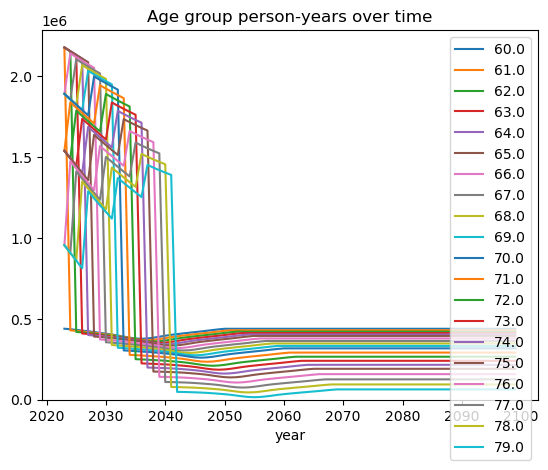

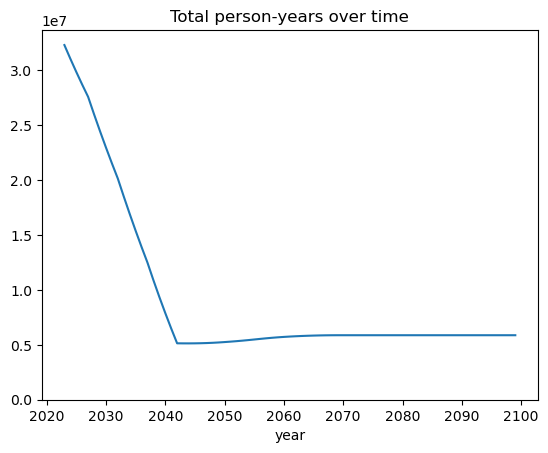

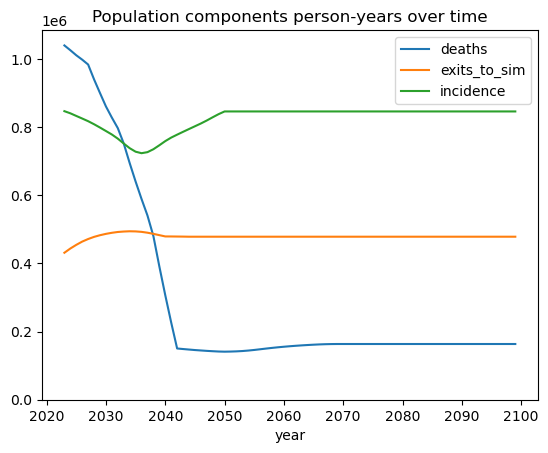

sex     age_start  age_end  year_start  year_end
Female  60.0       65.0     2021        2022        1.110797e+07
                            2022        2023        1.111329e+07
                            2023        2024        1.106421e+07
                            2024        2025        1.097848e+07
                            2025        2026        1.087420e+07
                                                        ...     
Male    75.0       80.0     2046        2047        7.005521e+06
                            2047        2048        6.901365e+06
                            2048        2049        6.774463e+06
                            2049        2050        6.653028e+06
                            2050        2051        6.564022e+06
Length: 240, dtype: float64

In [12]:
age_groups.plot()
plt.ylim(bottom=0)
plt.title("Age group person-years over time")
plt.show()
age_groups.sum(axis=1).plot()
plt.ylim(bottom=0)
plt.title("Total person-years over time")
plt.show()
categories.plot()
plt.ylim(bottom=0)
plt.title("Population components person-years over time")
plt.show()

forecasted_pop = (
    art.load(FORECASTED_POP_KEY)
    .query("age_start >=60 & age_start<80")
    .mean(axis=1)
    .droplevel(["location"])
)
forecasted_pop